In [1]:
# Author: Nicolas Boulanger-Lewandowski
# University of Montreal (2012)
# RNN-RBM deep learning tutorial
# More information at http://deeplearning.net/tutorial/rnnrbm.html
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys

import glob
import os
import sys

import numpy
try:
    import pylab
except ImportError:
    print ("pylab isn't available. If you use its functionality, it will crash.")
    print("It can be installed with 'pip install -q Pillow'")

from midi.utils import midiread, midiwrite
import theano
import theano.tensor as T
from theano.tensor.shared_randomstreams import RandomStreams


import cPickle
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.contrib import learn
from sklearn.metrics import mean_squared_error
import os
from tqdm import tqdm
import seaborn as sns
sys.path.append("music_rnn")
import pygame
from matplotlib import pyplot as plt
import midi_util
import feature_encoder
import music_lstm
import time
#RATHER THAN USE A HUGE DIRECT INTEGER ENCODING - TRY A DICTIONARY MAPPING


#Don't use a python long as this don't work on 32 bits computers.
numpy.random.seed(0xbeef)
rng = RandomStreams(seed=numpy.random.randint(1 << 30))
theano.config.warn.subtensor_merge_bug = False



/Users/danshiebler/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:

def build_rbm(v, W, bv, bh, k):
    '''Construct a k-step Gibbs chain starting at v for an RBM.

    v : Theano vector or matrix
        If a matrix, multiple chains will be run in parallel (batch).
    W : Theano matrix
        Weight matrix of the RBM.
    bv : Theano vector
        Visible bias vector of the RBM.
    bh : Theano vector
        Hidden bias vector of the RBM.
    k : scalar or Theano scalar
        Length of the Gibbs chain.

    Return a (v_sample, cost, monitor, updates) tuple:

    v_sample : Theano vector or matrix with the same shape as `v`
        Corresponds to the generated sample(s).
    cost : Theano scalar
        Expression whose gradient with respect to W, bv, bh is the CD-k
        approximation to the log-likelihood of `v` (training example) under the
        RBM. The cost is averaged in the batch case.
    monitor: Theano scalar
        Pseudo log-likelihood (also averaged in the batch case).
    updates: dictionary of Theano variable -> Theano variable
        The `updates` object returned by scan.
    '''
    def gibbs_step(v):
        mean_h = T.nnet.sigmoid(T.dot(v, W) + bh)
        h = rng.binomial(size=mean_h.shape, n=1, p=mean_h,
                         dtype=theano.config.floatX)
        mean_v = T.nnet.sigmoid(T.dot(h, W.T) + bv)
        v = rng.binomial(size=mean_v.shape, n=1, p=mean_v,
                         dtype=theano.config.floatX)
        return mean_v, v


    chain, updates = theano.scan(lambda v: gibbs_step(v)[1], outputs_info=[v], n_steps=k)

    v_sample = chain[-1] #vsample is the final output of the gibbs chain - the sampled vector from the rbm

    mean_v = gibbs_step(v_sample)[0]
    monitor = T.xlogx.xlogy0(v, mean_v) + T.xlogx.xlogy0(1 - v, 1 - mean_v)
    monitor = monitor.sum() / v.shape[0]

    def free_energy(v):
        return -(v * bv).sum() - T.log(1 + T.exp(T.dot(v, W) + bh)).sum()
    #the cost is based on the difference in free energy between v and v_sample
    cost = (free_energy(v) - free_energy(v_sample)) / v.shape[0]

    return v_sample, cost, monitor, updates










In [3]:

def shared_normal(num_rows, num_cols, scale=1):
    '''Initialize a matrix shared variable with normally distributed
    elements.'''
    return theano.shared(numpy.random.normal(
        scale=scale, size=(num_rows, num_cols)).astype(theano.config.floatX))


def shared_zeros(*shape):
    '''Initialize a vector shared variable with zero elements.'''
    return theano.shared(numpy.zeros(shape, dtype=theano.config.floatX))


def build_rnnrbm(n_visible, n_hidden, n_hidden_recurrent):
    '''Construct a symbolic RNN-RBM and initialize parameters.

    n_visible : integer
        Number of visible units.
    n_hidden : integer
        Number of hidden units of the conditional RBMs.
    n_hidden_recurrent : integer
        Number of hidden units of the RNN.

    Return a (v, v_sample, cost, monitor, params, updates_train, v_t,
    updates_generate) tuple:

    v : Theano matrix
        Symbolic variable holding an input sequence (used during training)
    v_sample : Theano matrix
        Symbolic variable holding the negative particles for CD log-likelihood
        gradient estimation (used during training)
    cost : Theano scalar
        Expression whose gradient (considering v_sample constant) corresponds
        to the LL gradient of the RNN-RBM (used during training)
    monitor : Theano scalar
        Frame-level pseudo-likelihood (useful for monitoring during training)
    params : tuple of Theano shared variables
        The parameters of the model to be optimized during training.
    updates_train : dictionary of Theano variable -> Theano variable
        Update object that should be passed to theano.function when compiling
        the training function.
    v_t : Theano matrix
        Symbolic variable holding a generated sequence (used during sampling)
    updates_generate : dictionary of Theano variable -> Theano variable
        Update object that should be passed to theano.function when compiling
        the generation function.'''

    W = shared_normal(n_visible, n_hidden, 0.01)
    bv = shared_zeros(n_visible)
    bh = shared_zeros(n_hidden)
    Wuh = shared_normal(n_hidden_recurrent, n_hidden, 0.0001)
    Wuv = shared_normal(n_hidden_recurrent, n_visible, 0.0001)
    Wvu = shared_normal(n_visible, n_hidden_recurrent, 0.0001)
    Wuu = shared_normal(n_hidden_recurrent, n_hidden_recurrent, 0.0001)
    bu = shared_zeros(n_hidden_recurrent)

    params = W, bv, bh, Wuh, Wuv, Wvu, Wuu, bu  # learned parameters as shared
                                                # variables

    v = T.matrix()  # a training sequence
    u0 = T.zeros((n_hidden_recurrent,))  # initial value for the RNN hidden
                                         # units

    # If `v_t` is given, deterministic recurrence to compute the variable
    # biases bv_t, bh_t at each time step. If `v_t` is None, same recurrence
    # but with a separate Gibbs chain at each time step to sample (generate)
    # from the RNN-RBM. The resulting sample v_t is returned in order to be
    # passed down to the sequence history.
    def recurrence(v_t, u_tm1):
        bv_t = bv + T.dot(u_tm1, Wuv)
        bh_t = bh + T.dot(u_tm1, Wuh)
        generate = v_t is None
        if generate:
            v_t, _, _, updates = build_rbm(T.zeros((n_visible,)), W, bv_t,
                                           bh_t, k=25)
        u_t = T.tanh(bu + T.dot(v_t, Wvu) + T.dot(u_tm1, Wuu))
        
        return ([v_t, u_t], updates) if generate else [u_t, bv_t, bh_t]

    # For training, the deterministic recurrence is used to compute all the
    # {bv_t, bh_t, 1 <= t <= T} given v. Conditional RBMs can then be trained
    # in batches using those parameters.
    (u_t, bv_t, bh_t), updates_train = theano.scan(
        lambda v_t, u_tm1, *_: recurrence(v_t, u_tm1),
        sequences=v, outputs_info=[u0, None, None], non_sequences=params)

    #Build this rbm based on the bias vectors that we already found 
    v_sample, cost, monitor, updates_rbm = build_rbm(v, W, bv_t[:], bh_t[:],
                                                     k=15)
    updates_train.update(updates_rbm)

    # symbolic loop for sequence generation
    (v_t, u_t), updates_generate = theano.scan(
        lambda u_tm1, *_: recurrence(None, u_tm1),
        outputs_info=[None, u0], non_sequences=params, n_steps=200)

    return (v, v_sample, cost, monitor, params, updates_train, v_t,
            updates_generate)



In [6]:

class RnnRbm:
    '''Simple class to train an RNN-RBM from MIDI files and to generate sample
    sequences.'''

    def __init__(
        self,
        n_hidden=150,
        n_hidden_recurrent=100,
        lr=0.001,
        r=(21, 109),
        dt=0.3
    ):
        '''Constructs and compiles Theano functions for training and sequence
        generation.

        n_hidden : integer
            Number of hidden units of the conditional RBMs.
        n_hidden_recurrent : integer
            Number of hidden units of the RNN.
        lr : float
            Learning rate
        r : (integer, integer) tuple
            Specifies the pitch range of the piano-roll in MIDI note numbers,
            including r[0] but not r[1], such that r[1]-r[0] is the number of
            visible units of the RBM at a given time step. The default (21,
            109) corresponds to the full range of piano (88 notes).
        dt : float
            Sampling period when converting the MIDI files into piano-rolls, or
            equivalently the time difference between consecutive time steps.'''

        self.r = r
        self.dt = dt
        (v, v_sample, cost, monitor, params, updates_train, v_t,
            updates_generate) = build_rnnrbm(
                r[1] - r[0],
                n_hidden,
                n_hidden_recurrent
            )

        gradient = T.grad(cost, params, consider_constant=[v_sample])
        updates_train.update(
            ((p, p - lr * g) for p, g in zip(params, gradient))
        )
        self.train_function = theano.function(
            [v],
            monitor,
            updates=updates_train
        )
        self.generate_function = theano.function(
            [],
            v_t,
            updates=updates_generate
        )

    def train(self, files, batch_size=100, num_epochs=200):
        '''Train the RNN-RBM via stochastic gradient descent (SGD) using MIDI
        files converted to piano-rolls.

        files : list of strings
            List of MIDI files that will be loaded as piano-rolls for training.
        batch_size : integer
            Training sequences will be split into subsequences of at most this
            size before applying the SGD updates.
        num_epochs : integer
            Number of epochs (pass over the training set) performed. The user
            can safely interrupt training with Ctrl+C at any time.'''

        assert len(files) > 0, 'Training set is empty!' \
                               ' (did you download the data files?)'
        dataset = [midiread(f, self.r,
                            self.dt).piano_roll.astype(theano.config.floatX)
                   for f in tqdm(files[:3])]

        try:
            for epoch in range(num_epochs):
                numpy.random.shuffle(dataset)
                costs = []

                for s, sequence in tqdm(enumerate(dataset)):
                    for i in range(0, len(sequence), batch_size):
                        cost = self.train_function(sequence[i:i + batch_size])
                        costs.append(cost)

                print('Epoch %i/%i' % (epoch + 1, num_epochs))
                sys.stdout.flush()

        except KeyboardInterrupt:
            print('Interrupted by user.')

    def generate(self, filename, show=True):
        '''Generate a sample sequence, plot the resulting piano-roll and save
        it as a MIDI file.

        filename : string
            A MIDI file will be created at this location.
        show : boolean
            If True, a piano-roll of the generated sequence will be shown.'''

        piano_roll = self.generate_function()
        midiwrite(filename, piano_roll, self.r, self.dt)
        if show:
            extent = (0, self.dt * len(piano_roll)) + self.r
            pylab.figure()
            pylab.imshow(piano_roll.T, origin='lower', aspect='auto',
                         interpolation='nearest', cmap=pylab.cm.gray_r,
                         extent=extent)
            pylab.xlabel('time (s)')
            pylab.ylabel('MIDI note number')
            pylab.title('generated piano-roll')


def test_rnnrbm(batch_size=100, num_epochs=200):
    model = RnnRbm()
    re = 'data/Nottingham/train/*.mid'
    model.train(glob.glob(re),
                batch_size=batch_size, num_epochs=num_epochs)
    return model



100%|██████████| 3/3 [00:00<00:00, 126.33it/s]
3it [00:00, 12.25it/s]

Epoch 1/200



3it [00:00, 12.06it/s]

Epoch 2/200



3it [00:00, 12.27it/s]

Epoch 3/200



3it [00:00, 13.18it/s]

Epoch 4/200



3it [00:00, 12.32it/s]

Epoch 5/200



3it [00:00, 12.86it/s]

Epoch 6/200



3it [00:00, 12.95it/s]

Epoch 7/200



3it [00:00, 12.80it/s]

Epoch 8/200



3it [00:00, 13.26it/s]

Epoch 9/200



3it [00:00, 12.93it/s]

Epoch 10/200



3it [00:00, 13.07it/s]

Epoch 11/200



3it [00:00, 12.58it/s]

Epoch 12/200



3it [00:00, 10.66it/s]

Epoch 13/200



3it [00:00, 12.95it/s]

Epoch 14/200



3it [00:00, 12.85it/s]

Epoch 15/200



3it [00:00, 13.13it/s]

Epoch 16/200



3it [00:00, 12.95it/s]

Epoch 17/200



3it [00:00, 12.98it/s]

Epoch 18/200



3it [00:00, 13.65it/s]

Epoch 19/200



3it [00:00, 12.90it/s]

Epoch 20/200



3it [00:00, 12.87it/s]

Epoch 21/200



3it [00:00, 12.83it/s]

Epoch 22/200



3it [00:00, 12.66it/s]

Epoch 23/200



3it [00:00, 13.07it/s]

Epoch 24/200



3it [00:00, 12.68it/s]

Epoch 25/200



3it [00:00, 12.58it/s]

Epoch 26/200



3it [00:00, 13.35it/s]

Epoch 27/200



3it [00:00, 12.90it/s]

Epoch 28/200



3it [00:00, 12.58it/s]

Epoch 29/200



3it [00:00, 12.97it/s]

Epoch 30/200



3it [00:00, 13.09it/s]

Epoch 31/200



3it [00:00, 13.39it/s]

Epoch 32/200



3it [00:00, 13.20it/s]

Epoch 33/200



3it [00:00, 11.04it/s]

Epoch 34/200



3it [00:00, 12.99it/s]

Epoch 35/200



3it [00:00, 13.23it/s]

Epoch 36/200



3it [00:00, 13.34it/s]

Epoch 37/200



3it [00:00, 13.27it/s]

Epoch 38/200



3it [00:00, 13.76it/s]

Epoch 39/200



3it [00:00, 12.82it/s]

Epoch 40/200



3it [00:00, 13.28it/s]

Epoch 41/200



3it [00:00, 13.10it/s]

Epoch 42/200



3it [00:00, 13.26it/s]

Epoch 43/200



3it [00:00, 13.48it/s]

Epoch 44/200



3it [00:00, 13.47it/s]

Epoch 45/200



3it [00:00, 12.76it/s]

Epoch 46/200



3it [00:00, 13.28it/s]

Epoch 47/200



3it [00:00, 13.03it/s]

Epoch 48/200



3it [00:00, 13.05it/s]

Epoch 49/200



3it [00:00, 12.94it/s]

Epoch 50/200



3it [00:00, 13.42it/s]

Epoch 51/200



3it [00:00, 12.47it/s]

Epoch 52/200



3it [00:00, 13.04it/s]

Epoch 53/200



3it [00:00, 13.78it/s]

Epoch 54/200



3it [00:00, 13.12it/s]

Epoch 55/200



3it [00:00, 13.70it/s]

Epoch 56/200



3it [00:00, 13.15it/s]

Epoch 57/200



3it [00:00, 13.09it/s]

Epoch 58/200



3it [00:00, 13.12it/s]

Epoch 59/200



3it [00:00, 12.91it/s]

Epoch 60/200



3it [00:00, 13.59it/s]

Epoch 61/200



3it [00:00, 12.87it/s]

Epoch 62/200



3it [00:00, 13.18it/s]

Epoch 63/200



3it [00:00, 12.68it/s]

Epoch 64/200



3it [00:00, 13.17it/s]

Epoch 65/200



3it [00:00, 12.11it/s]

Epoch 66/200



3it [00:00, 12.74it/s]

Epoch 67/200



3it [00:00, 12.13it/s]

Epoch 68/200



3it [00:00, 10.54it/s]

Epoch 69/200



3it [00:00, 11.85it/s]

Epoch 70/200



3it [00:00, 12.70it/s]

Epoch 71/200



3it [00:00, 13.13it/s]

Epoch 72/200



3it [00:00, 12.22it/s]

Epoch 73/200



3it [00:00, 10.95it/s]

Epoch 74/200



3it [00:00, 10.90it/s]

Epoch 75/200



3it [00:00, 11.84it/s]

Epoch 76/200



3it [00:00, 12.77it/s]

Epoch 77/200



3it [00:00, 12.46it/s]

Epoch 78/200



3it [00:00, 12.48it/s]

Epoch 79/200



3it [00:00, 12.08it/s]

Epoch 80/200



3it [00:00, 13.25it/s]

Epoch 81/200



3it [00:00, 13.34it/s]

Epoch 82/200



3it [00:00, 12.34it/s]

Epoch 83/200



3it [00:00, 11.20it/s]

Epoch 84/200



3it [00:00, 12.76it/s]

Epoch 85/200



3it [00:00, 12.47it/s]

Epoch 86/200



3it [00:00, 12.80it/s]

Epoch 87/200



3it [00:00, 10.78it/s]

Epoch 88/200



3it [00:00, 12.77it/s]

Epoch 89/200



3it [00:00, 12.55it/s]

Epoch 90/200



3it [00:00, 12.92it/s]

Epoch 91/200



3it [00:00, 12.78it/s]

Epoch 92/200



3it [00:00, 11.86it/s]

Epoch 93/200



3it [00:00, 10.40it/s]

Epoch 94/200



3it [00:00, 11.67it/s]

Epoch 95/200



3it [00:00, 12.05it/s]

Epoch 96/200



3it [00:00, 12.49it/s]

Epoch 97/200



3it [00:00, 12.40it/s]

Epoch 98/200



3it [00:00, 12.07it/s]

Epoch 99/200



3it [00:00, 12.14it/s]

Epoch 100/200



3it [00:00, 12.79it/s]

Epoch 101/200



3it [00:00, 12.85it/s]

Epoch 102/200



3it [00:00, 12.15it/s]

Epoch 103/200



3it [00:00, 13.38it/s]

Epoch 104/200



3it [00:00, 13.78it/s]

Epoch 105/200



3it [00:00, 13.25it/s]

Epoch 106/200



3it [00:00, 13.58it/s]

Epoch 107/200



3it [00:00, 13.35it/s]

Epoch 108/200



3it [00:00, 13.64it/s]

Epoch 109/200



3it [00:00, 13.17it/s]

Epoch 110/200



3it [00:00, 13.41it/s]

Epoch 111/200



3it [00:00, 13.46it/s]

Epoch 112/200



3it [00:00, 12.63it/s]

Epoch 113/200



3it [00:00, 13.65it/s]

Epoch 114/200



3it [00:00, 13.42it/s]

Epoch 115/200



3it [00:00, 13.53it/s]

Epoch 116/200



3it [00:00, 12.88it/s]

Epoch 117/200



3it [00:00, 13.23it/s]

Epoch 118/200



3it [00:00, 13.34it/s]

Epoch 119/200



3it [00:00, 13.49it/s]

Epoch 120/200



3it [00:00, 12.93it/s]

Epoch 121/200



3it [00:00, 13.43it/s]

Epoch 122/200



3it [00:00, 13.91it/s]

Epoch 123/200



3it [00:00, 12.99it/s]

Epoch 124/200



3it [00:00, 12.79it/s]

Epoch 125/200



3it [00:00, 12.83it/s]

Epoch 126/200



3it [00:00, 12.93it/s]

Epoch 127/200



3it [00:00, 12.43it/s]

Epoch 128/200



3it [00:00, 13.48it/s]

Epoch 129/200



3it [00:00, 12.85it/s]

Epoch 130/200



3it [00:00, 12.40it/s]

Epoch 131/200



3it [00:00, 13.08it/s]

Epoch 132/200



3it [00:00, 13.91it/s]

Epoch 133/200



3it [00:00, 12.77it/s]

Epoch 134/200



3it [00:00, 13.00it/s]

Epoch 135/200



3it [00:00, 13.08it/s]

Epoch 136/200



3it [00:00, 13.26it/s]

Epoch 137/200



3it [00:00, 12.76it/s]

Epoch 138/200



3it [00:00, 12.63it/s]

Epoch 139/200



3it [00:00, 13.41it/s]

Epoch 140/200



3it [00:00, 12.74it/s]

Epoch 141/200



3it [00:00, 12.42it/s]

Epoch 142/200



3it [00:00, 12.61it/s]

Epoch 143/200



3it [00:00, 11.94it/s]

Epoch 144/200



3it [00:00, 12.21it/s]

Epoch 145/200



3it [00:00, 12.57it/s]

Epoch 146/200



3it [00:00, 13.20it/s]

Epoch 147/200



3it [00:00, 12.69it/s]

Epoch 148/200



3it [00:00, 10.77it/s]

Epoch 149/200



3it [00:00, 12.38it/s]

Epoch 150/200



3it [00:00, 10.46it/s]

Epoch 151/200



3it [00:00, 13.09it/s]

Epoch 152/200



3it [00:00, 12.73it/s]

Epoch 153/200



3it [00:00, 12.12it/s]

Epoch 154/200



3it [00:00, 12.42it/s]

Epoch 155/200



3it [00:00, 12.78it/s]

Epoch 156/200



3it [00:00, 13.09it/s]

Epoch 157/200



3it [00:00, 13.09it/s]

Epoch 158/200



3it [00:00, 13.32it/s]

Epoch 159/200



3it [00:00, 12.36it/s]

Epoch 160/200



3it [00:00, 11.94it/s]

Epoch 161/200



3it [00:00, 12.65it/s]

Epoch 162/200



3it [00:00, 10.42it/s]

Epoch 163/200



3it [00:00, 12.51it/s]

Epoch 164/200



3it [00:00, 12.60it/s]

Epoch 165/200



3it [00:00, 12.55it/s]

Epoch 166/200



3it [00:00, 12.74it/s]

Epoch 167/200



3it [00:00, 12.65it/s]

Epoch 168/200



3it [00:00, 12.95it/s]

Epoch 169/200



3it [00:00, 11.79it/s]

Epoch 170/200



3it [00:00, 12.48it/s]

Epoch 171/200



3it [00:00, 12.59it/s]

Epoch 172/200



3it [00:00, 11.93it/s]

Epoch 173/200



3it [00:00, 12.46it/s]

Epoch 174/200



3it [00:00, 13.20it/s]

Epoch 175/200



3it [00:00, 12.36it/s]

Epoch 176/200



3it [00:00, 12.16it/s]

Epoch 177/200



3it [00:00, 12.36it/s]

Epoch 178/200



3it [00:00, 12.87it/s]

Epoch 179/200



3it [00:00, 12.46it/s]

Epoch 180/200



3it [00:00, 12.32it/s]

Epoch 181/200



3it [00:00, 12.96it/s]

Epoch 182/200



3it [00:00, 12.31it/s]

Epoch 183/200



3it [00:00, 12.45it/s]

Epoch 184/200



3it [00:00, 12.47it/s]

Epoch 185/200



3it [00:00, 13.39it/s]

Epoch 186/200



3it [00:00, 10.31it/s]

Epoch 187/200



3it [00:00, 11.95it/s]

Epoch 188/200



3it [00:00, 11.00it/s]

Epoch 189/200



3it [00:00, 11.95it/s]

Epoch 190/200



3it [00:00, 12.78it/s]

Epoch 191/200



3it [00:00, 12.89it/s]

Epoch 192/200



3it [00:00, 12.77it/s]

Epoch 193/200



3it [00:00, 12.37it/s]

Epoch 194/200



3it [00:00, 13.12it/s]

Epoch 195/200



3it [00:00, 13.02it/s]

Epoch 196/200



3it [00:00, 12.57it/s]

Epoch 197/200



3it [00:00, 13.08it/s]

Epoch 198/200



3it [00:00, 12.86it/s]

Epoch 199/200



3it [00:00, 12.31it/s]

Epoch 200/200


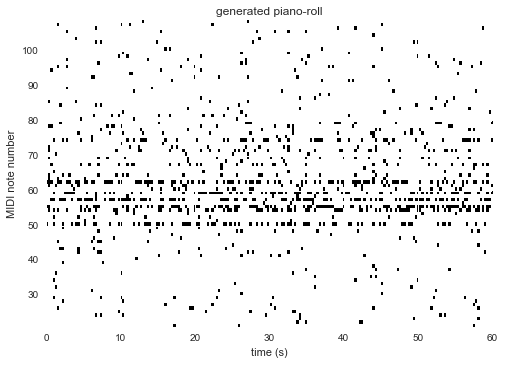

In [7]:
model = test_rnnrbm()
model.generate('../music_outputs/composition_theano.midi')
# model.generate('sample2.mid')
# pylab.show()

In [ ]:

def dump_midi(midi_vec, filename, time_step=32, resolution=480, n=128):
    M  = midi_util.MidiWriter()
    M.dump_sequence_to_midi(midi_vec, filename, time_step, resolution)

def plot_midi(midi_vec, n=128):
    plt.imshow(midi_vec, extent=[0, 1, 0, 1])

    
re = 'data/music_all/train/*.mid'
files = glob.glob(re)
f = files[0]
r=(21, 109)
dt=0.3
m = midiread(f, r, dt).piano_roll
plot_midi(m)